In [1]:
import torch
import torchvision.datasets
import torchvision.models
import torchvision.transforms
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
from PIL import Image, ImageOps
import os, sys, math, random, copy, time
import datasets, custom_transforms, models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Settings

In [2]:

# Datasets to examine

description = 'DanielCheckpoints_cleanedReduced_224_v1'


CKPT_PATH=os.path.join(description,'balance[epoch_8_loss_0.103_acc_0.965].pt')



N_CLASSES = 2
unbias_dataset = False # False to use ALL data in the dataset, True to cut the number of elements in each set to roughly the same number.
CLASS_NAMES = ['NONCOVID', 'COVID' ]#['Normal', 'Pneumonia', 'COVID-19'] #  in order of 0, 1, 2
BATCH_SIZE = 16
switch_pair = ["internal_test_Daniel", "Baseline",
               "NoSup_uncropped", "Gusarev_uncropped", "Rajaraman_uncropped",
              "NoSup_cropped", "Gusarev_cropped" , "Rajaraman_cropped"]
interp_mode = torchvision.transforms.InterpolationMode.NEAREST
top_cutoff_percent = 0.08
image_size_to_VGG = 224


CKPT_PATH = os.path.join('checkpoints', str(N_CLASSES)+"Class", CKPT_PATH)
# Dataset saving directories
save_picture_directory = Path(os.path.join("reports", str(N_CLASSES)+"Class", str(description))) # directory to save confusion matrices
save_picture_directory.mkdir(parents=True, exist_ok=True)


# Transforms
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225]) # ImageNet mean and std for normalisation
test_transforms = torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            custom_transforms.COVIDNetProcessing(top_cutoff_percent),
                            torchvision.transforms.Resize(image_size_to_VGG, interpolation=interp_mode),
                            torchvision.transforms.CenterCrop(image_size_to_VGG),
                            normalize,
                            ])

# Datasets

In [3]:
dataset_normal={
    "Baseline": "D:/data/JSRT/JSRT/", # images are NOT histogram-equalized
    "NoSup_uncropped":"D:/data/JSRT/JSRT_preprocessed_all/bilinear/uncropped/",
    "NoSup_cropped":"D:/data/JSRT/JSRT_preprocessed_all/bilinear/cropped/",
    "Gusarev_uncropped":"../GusarevBoneSuppression/bone_suppressed/JSRT_all_v5_HQ_nonEqualised_noInputHistEq_177-20-20_20210802_bilinear_uncropped/",
    "Rajaraman_uncropped":"../Rajaraman_ResNet_BS/bone_suppressed/JSRT_all_v2_HQ_notEqualised_inputsNotEqualised_177-20-20_20210802_bilinear_uncropped/",
    "Gusarev_cropped":"../GusarevBoneSuppression/bone_suppressed/JSRT_all_v5_HQ_nonEqualised_noInputHistEq_177-20-20_20210802_bilinear_cropped/",
    "Rajaraman_cropped":"../Rajaraman_ResNet_BS/bone_suppressed/JSRT_all_v2_HQ_notEqualised_inputsNotEqualised_177-20-20_20210802_bilinear_cropped/",
               #"Ren":"../RenGeBoneSuppression/bone_suppressed/JSRT_all_v1_RenGe_Pretrained_256_noSeg_uncropped/"
               }
dataset_pneumonia={
    "Baseline": None,
    "NoSup_uncropped":None, 
    "NoSup_cropped":None, 
   "Gusarev_uncropped":None,
   "Rajaraman_uncropped":None,
   "Gusarev_cropped":None,
    "Rajaraman_cropped":None,
                  #"Ren": None
                  }
dataset_covid={
    "Baseline": "D:/data/QEH_COVID19_DATASET/QEH_Earliest_CXR_per_patient/all/", # images are NOT histogram-equalized
    "NoSup_uncropped":"D:/data/QEH_COVID19_DATASET/QEH_onePerPatient_all_preprocessed/bilinear/uncropped/",
    "NoSup_cropped":"D:/data/QEH_COVID19_DATASET/QEH_onePerPatient_all_preprocessed/bilinear/cropped/",
    "Gusarev_uncropped":"../GusarevBoneSuppression/bone_suppressed/QEH_onePerPatient_all_v5_HQ_nonEqualised_noInputHistEq_177-20-20_20210802_bilinear_uncropped/",
    "Rajaraman_uncropped":"../Rajaraman_ResNet_BS/bone_suppressed/QEH_onePerPatient_all_v2_HQ_notEqualised_inputsNotEqualised_177-20-20_20210802_bilinear_uncropped/",
    "Gusarev_cropped":"../GusarevBoneSuppression/bone_suppressed/QEH_onePerPatient_all_v5_HQ_nonEqualised_noInputHistEq_177-20-20_20210802_bilinear_cropped/",
    "Rajaraman_cropped":"../Rajaraman_ResNet_BS/bone_suppressed/QEH_onePerPatient_all_v2_HQ_notEqualised_inputsNotEqualised_177-20-20_20210802_bilinear_cropped/",
    #"Ren":"../RenGeBoneSuppression/bone_suppressed/QEH_onePerPatient_all_v1_RenGe_Pretrained_256_noSeg_uncropped/"
              }

def switchDataset(switch, dataset_normal=None, dataset_pneumonia=None, dataset_covid=None):
    if switch == "internal_test_Daniel":
        data_normal = "D:/data/DanielCustomNetwork/DanielDataSets_Original/test/NORMAL/"
        data_pneumonia = "D:/data/DanielCustomNetwork/DanielDataSets_Original/test/PNEUMONIA/"
        data_covid = "D:/data/DanielCustomNetwork/DanielDataSets_Original/test/COVID/"
    else:
        data_normal = dataset_normal[switch]
        data_pneumonia = dataset_pneumonia[switch]
        data_covid = dataset_covid[switch]
    return {'normal': data_normal, 'pneumonia': data_pneumonia, 'covid': data_covid}

# Model

In [4]:
# Speed up convolution algorithm
torch.backends.cudnn.benchmark=True

model = models.get_model_vgg16(N_CLASSES)
model = model.to(device)
model.eval()
if os.path.isfile(CKPT_PATH):
    print("=> loading checkpoint")
    checkpoint = torch.load(CKPT_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("=> loaded checkpoint")
else:
    print("=> no checkpoint found")
print("Model Loaded.")

=> no checkpoint found
Model Loaded.


# Training

In [5]:
predictions = {}
true_labels={}
for switch in switch_pair:
    # Dataset
    chosen_datasets = switchDataset(switch, dataset_normal, dataset_pneumonia, dataset_covid)
    test_dataset = datasets.Coviddataset(normal_path=chosen_datasets["normal"], pneumonia_path=chosen_datasets["pneumonia"], covid_path=chosen_datasets["covid"], 
                                         transform = test_transforms, NClasses=N_CLASSES, 
                                         unbias=unbias_dataset, channels=3) # RGB image
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=0, pin_memory=True)
    
    # Classify
    predictions[switch] = []
    true_labels[switch] = []
    for data in test_loader:
        inputs, labels, names = data['image'], data['label'], data['name']
        inputs = inputs.to(device)
        with torch.no_grad():
            preds = model(inputs)
            preds = preds.detach().clone()
            preds = torch.argmax(preds,1,False)
        
        # Append lists
        predictions[switch].append(preds.detach().cpu())
        true_labels[switch].append(labels.detach().cpu())
    predictions[switch] = torch.cat(predictions[switch])
    true_labels[switch] = torch.cat(true_labels[switch])
    

RAW DATASET STATISTICS:-----------
Normal:100, Pneumonia:100, COVID:100
2-Class Dataset Statistics:-----------
Noncovid:200, COVID:100


C:\Users\nfdlam\.conda\envs\AI_cuda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


None Path
RAW DATASET STATISTICS:-----------
Normal:241, Pneumonia:0, COVID:524
2-Class Dataset Statistics:-----------
Noncovid:241, COVID:524
None Path
RAW DATASET STATISTICS:-----------
Normal:241, Pneumonia:0, COVID:524
2-Class Dataset Statistics:-----------
Noncovid:241, COVID:524
None Path
RAW DATASET STATISTICS:-----------
Normal:241, Pneumonia:0, COVID:524
2-Class Dataset Statistics:-----------
Noncovid:241, COVID:524
None Path
RAW DATASET STATISTICS:-----------
Normal:241, Pneumonia:0, COVID:524
2-Class Dataset Statistics:-----------
Noncovid:241, COVID:524
None Path
RAW DATASET STATISTICS:-----------
Normal:241, Pneumonia:0, COVID:524
2-Class Dataset Statistics:-----------
Noncovid:241, COVID:524
None Path
RAW DATASET STATISTICS:-----------
Normal:241, Pneumonia:0, COVID:524
2-Class Dataset Statistics:-----------
Noncovid:241, COVID:524
None Path
RAW DATASET STATISTICS:-----------
Normal:241, Pneumonia:0, COVID:524
2-Class Dataset Statistics:-----------
Noncovid:241, COVID:524

# Visualisation

Calculating...


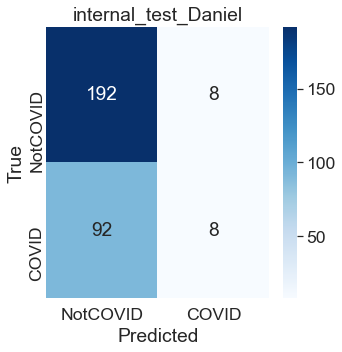

Confusion Matrix:
[[192   8]
 [ 92   8]]
Sensitivity: 8.00%
Specificity: 96.00%
NPV: 67.61%
Accuracy: 66.67%


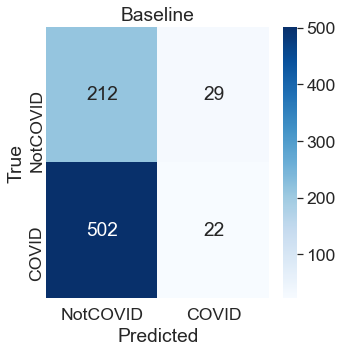

Confusion Matrix:
[[212  29]
 [502  22]]
Sensitivity: 4.20%
Specificity: 87.97%
NPV: 29.69%
Accuracy: 30.59%


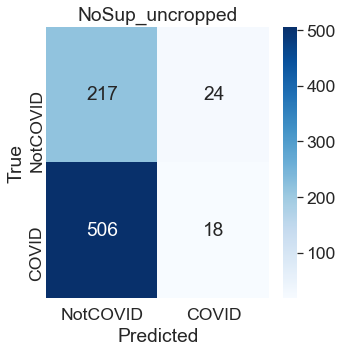

Confusion Matrix:
[[217  24]
 [506  18]]
Sensitivity: 3.44%
Specificity: 90.04%
NPV: 30.01%
Accuracy: 30.72%


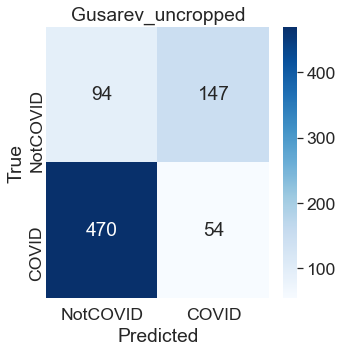

Confusion Matrix:
[[ 94 147]
 [470  54]]
Sensitivity: 10.31%
Specificity: 39.00%
NPV: 16.67%
Accuracy: 19.35%


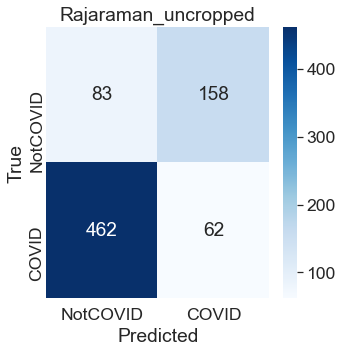

Confusion Matrix:
[[ 83 158]
 [462  62]]
Sensitivity: 11.83%
Specificity: 34.44%
NPV: 15.23%
Accuracy: 18.95%


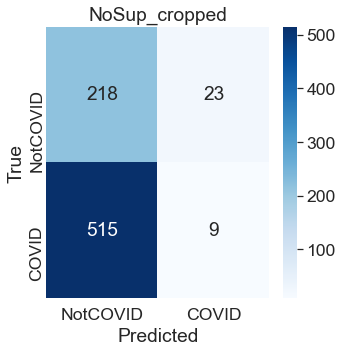

Confusion Matrix:
[[218  23]
 [515   9]]
Sensitivity: 1.72%
Specificity: 90.46%
NPV: 29.74%
Accuracy: 29.67%


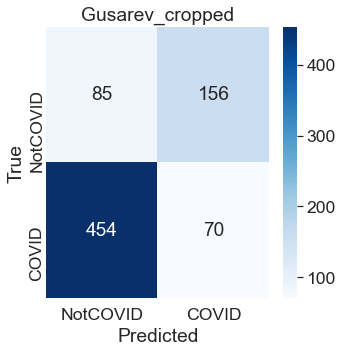

Confusion Matrix:
[[ 85 156]
 [454  70]]
Sensitivity: 13.36%
Specificity: 35.27%
NPV: 15.77%
Accuracy: 20.26%


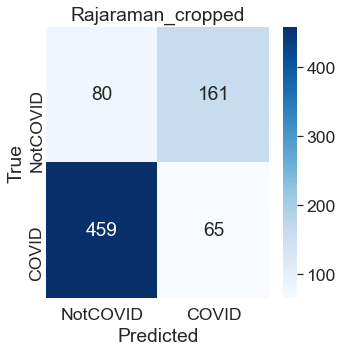

Confusion Matrix:
[[ 80 161]
 [459  65]]
Sensitivity: 12.40%
Specificity: 33.20%
NPV: 14.84%
Accuracy: 18.95%
Baseline-Baseline
T-score : nan
McNemar Contingency Table:---
[[ 51   0]
 [  0 714]]
McNemar Chi-Squared : nan
Baseline-NoSup_uncropped
T-score : 0.9654889788694847
McNemar Contingency Table:---
[[  3  48]
 [ 39 675]]
McNemar Chi-Squared : 0.9310344827586207
Baseline-Gusarev_uncropped
T-score : 10.753082289197769
McNemar Contingency Table:---
[[ 14  37]
 [187 527]]
McNemar Chi-Squared : 100.44642857142857
Baseline-Rajaraman_uncropped
T-score : 11.842083542190334
McNemar Contingency Table:---
[[ 15  36]
 [205 509]]
McNemar Chi-Squared : 118.5103734439834
Baseline-NoSup_cropped
T-score : 2.17191648902765
McNemar Contingency Table:---
[[  3  48]
 [ 29 685]]
McNemar Chi-Squared : 4.688311688311688
Baseline-Gusarev_cropped
T-score : 12.34455184251469
McNemar Contingency Table:---
[[ 18  33]
 [208 506]]
McNemar Chi-Squared : 127.0746887966805
Baseline-Rajaraman_cropped
T-score : 12.4

C:\Users\nfdlam\.conda\envs\AI_cuda\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\nfdlam\.conda\envs\AI_cuda\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in long_scalars


In [9]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(font_scale=1.6)
def prediction_outputs(preds, true_labels=None, n_class = 2, title="", save_file=None, plot_figure=True, verbose=True):
    if true_labels is not None:
        if preds.ndim ==2:
            preds_closest_ints = preds.argmax(axis=1)
        elif preds.ndim==1:
            preds_closest_ints = preds
        idx = preds_closest_ints == true_labels
        
        CM = confusion_matrix(true_labels, preds_closest_ints)
        
        if plot_figure:
            fig = plt.figure(figsize=(5,5))
            ax = plt.axes()
            hm = sns.heatmap(CM, annot=True, 
                        fmt='d', cmap='Blues')
            hm.set_title(title)
            hm.set_xlabel("Predicted")
            hm.set_ylabel("True")
            hm.set_xticklabels(labels=("NotCOVID","COVID"), ha='center')
            hm.set_yticklabels(labels=("NotCOVID","COVID"), ha='center', rotation=90)
            #ax.set(title=title, xlabel="Predicted", ylabel="True")
            if save_file is not None:
                plt.savefig(fname=save_file)
            plt.show()
        
        num_classes = []
        if n_class == 2:
            num_classes.append(CM[0][0] + CM[0][1])
            num_classes.append(CM[1][0] + CM[1][1])
            
            sensitivity = CM[1][1]/(CM[1][1] + CM[1][0]) # TP/(TP+FN)
            specificity = CM[0][0]/(CM[0][0] + CM[0][1]) # TN/(TN+FP)
            NPV = CM[0][0]/(CM[0][0] + CM[1][0]) # TN/(TN+FN)
            overacc =(CM[0][0]+CM[1][1])/ (num_classes[0]+num_classes[1])
        if n_class == 3:
            overacc =(CM[0][0]+CM[1][1]+CM[2][2])/ (num_classes[0]+num_classes[1]+num_classes[2])
        if verbose:
            print("Confusion Matrix:")
            print(CM)
            print('Sensitivity: {sens:.2f}%'.format(sens=sensitivity*100))
            print('Specificity: {spec:.2f}%'.format(spec=specificity*100))
            print('NPV: {npv:.2f}%'.format(npv=NPV*100))
            print('Accuracy: {acc:.2f}%'.format(acc=overacc*100))
        
        outputs={"CM":CM, "Sensitivity":sensitivity, "Specificity":specificity, "NPV":NPV, "Accuracy":overacc}
        return outputs
    else:
        if n_class ==2:
            idx_nonCovid = preds[:,0] > preds[:,1]
            idx_Covid =  preds[:,0] <= preds[:,1]
            print("Proportion classed as non-COVID: " +str(np.sum(idx_nonCovid)/len(idx_nonCovid)))
            print("Proportion classed as COVID: " +str(np.sum(idx_Covid)/len(idx_Covid)))
        if n_class ==3:
            # 3 class
            idx_normal = np.logical_and( preds[:,0] > preds[:,1] , preds[:,0] > preds[:,2])
            idx_pneumonia = np.logical_and( preds[:,1] > preds[:,0] , preds[:,1] > preds[:,2])
            idx_COVID = np.logical_and( preds[:,2] > preds[:,1] , preds[:,2] > preds[:,0])

            print("Proportion classed as normal: " +str(np.sum(idx_normal)/len(idx_normal)))
            print("Proportion classed as pneumonia: " +str(np.sum(idx_pneumonia)/len(idx_pneumonia)))
            print("Proportion classed as COVID: " +str(np.sum(idx_COVID)/len(idx_COVID)))

def paired_t_test(array1, array2):
    #array1 = array1.argmax(axis=1)
    #array2 = array2.argmax(axis=1)
    
    x_diff = array1 - array2
    s_diff = np.std(x_diff)
    x_diff_mean = np.mean(x_diff)
    s_x = s_diff/np.sqrt(len(x_diff))
    
    t_score = np.abs(x_diff_mean/s_x)
    return t_score

def McNemar_test(test1, test2, negative_label=0, positive_label=1):
    #test1 = test1.argmax(axis=1)
    #test2 = test2.argmax(axis=1)
    
    test1_negative = test1==negative_label
    test1_positive = test1==positive_label
    test2_negative = test2==negative_label
    test2_positive = test2==positive_label
    
    # Contingency Table
    a = np.logical_and(test1_positive,test2_positive)
    b = np.logical_and(test1_positive,test2_negative)
    c = np.logical_and(test1_negative,test2_positive)
    d = np.logical_and(test1_negative,test2_negative)
    
    # McNemar Table:
    a = np.sum(a); b = np.sum(b) ; c = np.sum(c) ; d=np.sum(d)
    print("McNemar Contingency Table:---")
    print(np.asarray([[a,b],[c,d]]))
    return (np.abs(b-c))**2/(b+c)


# Calculate DL-only classification
print("Calculating...")
pandas_dict = {"Name":[], "Sensitivity":[], "Specificity":[], "NPV": [], "Accuracy":[]}
for counter, status in enumerate(switch_pair):
    a = Path(os.path.join(save_picture_directory))
    a.mkdir(parents=True, exist_ok=True)
    output = prediction_outputs(predictions[status].numpy(), true_labels[status].numpy() , 2, title=status, save_file=os.path.join(a,status+".png"))
    #if counter > 0:
    #    print("T-score {}: {}".format(status,paired_t_test(predictions["Baseline"].numpy(), predictions[status].numpy())))
    #    print("McNemar Chi-Squared {}: {}".format(status,McNemar_test(predictions["Baseline"].numpy(), predictions[status].numpy())))
    print("====================")
    # output to pandas
    pandas_dict["Name"].append(status)
    pandas_dict["Sensitivity"].append(output["Sensitivity"])
    pandas_dict["Specificity"].append(output["Specificity"])
    pandas_dict["NPV"].append(output["NPV"])
    pandas_dict["Accuracy"].append(output["Accuracy"])
    

for i, switch_i in enumerate(switch_pair[1:]):
    for switch_j in switch_pair[i+1:]:
        print("{}-{}".format(switch_i, switch_j))
        print("T-score : {}".format( paired_t_test(predictions[switch_i].numpy(), predictions[switch_j].numpy())))
        print("McNemar Chi-Squared : {}".format( McNemar_test(predictions[switch_i].numpy(), predictions[switch_j].numpy())))
print("Complete")
df = pd.DataFrame(pandas_dict)
print(df)